### Imports

In [1]:
import pandas as pd
import regex as re
from cleantext import clean
import pyarrow.feather as feather
from multiprocessing import Pool
import gc
import nltk
from nltk.util import ngrams
from nltk.corpus import words
import itertools
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import *
import time
from collections import Counter
import seaborn as sns

from sklearn.model_selection import train_test_split    # splitting the data 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

### Loading the dataset

In [3]:
import pandas as pd
import regex as re
from cleantext import clean
data = pd.read_csv("data/sample_preprocessed_ver_2023-03-24-1679664935.csv", index_col=0)

In [4]:
# convert the strings to lists
pattern = re.compile(r"\w+")
def string_to_list(s):
    return pattern.findall(s)

In [5]:
# sperate dataframes into chunks of 10000 in order to process
# without having everything in ram at once 
chunck_size = 10000
data_chunks = [data.iloc[i:i+chunck_size] for i in range(0, data.shape[0], chunck_size)]

In [6]:
for chunck in data_chunks:
    chunck['content'] = chunck['content'].apply(string_to_list)

/var/folders/gj/r8x5s5mn7jg12hs3c28wpg4c0000gn/T/ipykernel_50926/3069241047.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunck['content'] = chunck['content'].apply(string_to_list)


In [7]:
data = pd.concat(data_chunks)

In [8]:
len(data)

11991

### Simple Model - Logistic Regression

In [9]:
X_train, X_val, y_train, y_val = train_test_split(data['content'], data['type'], test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer=lambda x : x, max_features=200000)
vectorizer.fit(X_train)

CountVectorizer(analyzer=<function <lambda> at 0x16827e5f0>,
                max_features=200000)

In [11]:
X_train.shape

(9592,)

In [12]:
vectorizer.get_feature_names_out()

array(['a', 'aa', 'aaa', ..., 'zyuganov', 'zz', 'zzzz'], dtype=object)

In [13]:
X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [14]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [15]:
pred = logreg.predict(X_val)

In [16]:
accuracy_score(y_val, pred)

0.7664720600500416

In [17]:
from sklearn.metrics import f1_score

# y_val er pandas series, så omdanner også til ndarray
# positive = reliable
f1_score(pd.Series.to_numpy(y_val), pred, pos_label='reliable')

0.7582037996545768

[[480 147   0]
 [133 439   0]
 [  0   0   0]]


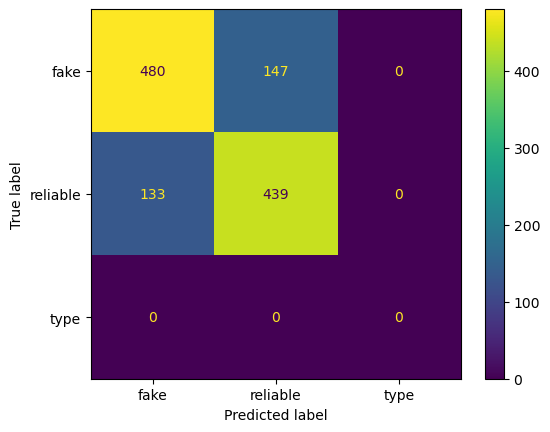

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# generating confusion matrix
cf_matrix = confusion_matrix(pd.Series.to_numpy(y_val), pred, labels=logreg.classes_)
print(cf_matrix)
# plotting to a heatmap
#sns.heatmap(cf_matrix, annot=True, fmt='g')
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=logreg.classes_).plot()



### Advanced Model - Naive Bayes

In [19]:
def to_bigrams(words):
    return list(nltk.bigrams(words))

In [20]:
chunck_size = 10000
data_chunks = [data.iloc[i:i+chunck_size] for i in range(0, data.shape[0], chunck_size)]

In [21]:
for chunck in data_chunks:
    chunck['content'] = chunck['content'].apply(to_bigrams)

/var/folders/gj/r8x5s5mn7jg12hs3c28wpg4c0000gn/T/ipykernel_50926/467942890.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunck['content'] = chunck['content'].apply(to_bigrams)


In [22]:
data = pd.concat(data_chunks)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(data['content'], data['type'], test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = TfidfVectorizer(analyzer=lambda x : x, max_features=50000)
vectorizer.fit(X_train)

TfidfVectorizer(analyzer=<function <lambda> at 0x28baaa0e0>, max_features=50000)

In [25]:
X_train.shape

(9592,)

In [26]:
X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [27]:
vectorizer.get_feature_names_out()

array([['aaron', 'dyke'],
       ['ab', 'num'],
       ['abadi', 'said'],
       ...,
       ['zombi', 'apocalyps'],
       ['zone', 'num'],
       ['zone', 'spoiler']], dtype=object)

In [28]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [29]:
pred = nb.predict(X_val)

In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, pred)

0.8065054211843202

In [31]:
from sklearn.metrics import f1_score
# y_val er pandas series, så omdanner også til ndarray
# positive = reliable
f1_score(pd.Series.to_numpy(y_val), pred, pos_label='reliable')

0.7890909090909091

[[533  94]
 [138 434]]


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (3).

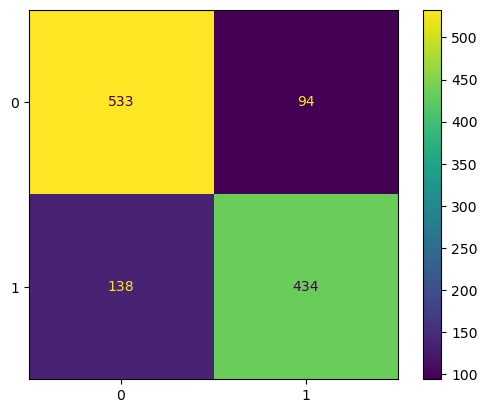

In [32]:
from sklearn.metrics import confusion_matrix
# generating confusion matrix
cf_matrix = confusion_matrix(pd.Series.to_numpy(y_val), pred)
print(cf_matrix)
# plotting to a heatmap
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=nb.classes_).plot()